## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)

# Suppress warnings
warnings.filterwarnings("ignore")

## Import Dataset

In [2]:
df = pd.read_csv('df_cleaned.csv')
df[['Age Group']].value_counts()

Age Group  
Youth          9198
Prime          6055
Experienced    3726
dtype: int64

## Initial Data Preprocessing

### Data Discretization and Binning

* **Objective**: The goal of this step is to categorize OVA values into meaningful bins with labels to simplify subsequent analysis.

* **Method**: Custom bins and labels are defined as follows: [0, 60, 70, 100] with labels 'Low,' 'Medium,' and 'High,' respectively.

* **Insight**: This discretization transforms continuous OVA values into three distinct categories, providing a foundation for classification tasks. It simplifies the prediction task by converting OVA into ordinal classes.

In [3]:
# Define custom bins and labels for categories
bins = [0, 60, 70, 100] 
labels = ['Low', 'Medium', 'High']

# Use pd.cut to categorize the OVA values
df['OVA'] = pd.cut(df['OVA'], bins=bins, labels=labels)
df

,Nationality,Age Group,OVA,Potential Rating,Club,Contract Duration (Years),Positions,Height,Weight,Preferred Foot,Sprint Speed,Reactions,Jumping,Stamina,Strength,Aggression,Vision,Composure,Skill Moves Rating,Attacking Work Rate,Defensive Work Rate,Pace,Shooting,Passing,Dribbling,Defending,Market Value
0,Argentina,Experienced,High,93,FC Barcelona,9.5,"RW, ST, CF",170.0,72.0,0,80,94,68,72,69,44,95,96,4,Medium,Low,85,92,91,95,38,103500000.0
1,Portugal,Experienced,High,92,Juventus,4.0,"ST, LW",187.0,83.0,1,91,95,95,84,78,63,82,95,5,High,Low,89,93,81,89,35,63000000.0
2,Slovenia,Prime,High,93,Atlético Madrid,9.0,GK,188.0,87.0,1,60,88,78,41,78,34,65,68,1,Medium,Medium,87,92,78,90,52,120000000.0
3,Belgium,Prime,High,91,Manchester City,8.0,"CAM, CM",181.0,70.0,1,76,91,63,89,74,76,94,91,4,High,High,76,86,93,88,64,129000000.0
4,Brazil,Prime,High,91,Paris Saint-Germain,5.0,"LW, CAM",175.0,68.0,1,89,91,62,81,50,51,90,93,5,High,Medium,91,85,86,94,36,132000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18974,China PR,Youth,Low,55,Wuhan Zall,4.0,CB,178.0,66.0,1,60,46,57,54,50,48,28,44,2,Medium,Medium,64,28,26,38,48,100000.0
18975,England,Youth,Low,67,Oldham Athletic,1.0,CM,175.0,65.0,1,64,51,58,43,47,40,47,38,2,Medium,Medium,64,40,48,49,35,130000.0
18976,England,Youth,Low,65,Derry City,1.0,CM,179.0,74.0,1,66,47,52,50,54,56,43,43,2,Medium,Medium,63,39,44,46,40,120000.0
18977,China PR,Youth,Low,57,Dalian YiFang FC,2.0,RW,175.0,69.0,1,55,33,45,46,48,31,46,45,2,Medium,Medium,58,49,41,49,30,100000.0


In [4]:
df[['Age Group', 'OVA', 'Attacking Work Rate', 'Defensive Work Rate']].value_counts()

Age Group    OVA     Attacking Work Rate  Defensive Work Rate
Youth        Medium  Medium               Medium                 2517
             Low     Medium               Medium                 2471
Prime        Medium  Medium               Medium                 1810
Experienced  Medium  Medium               Medium                 1072
Youth        Medium  High                 Medium                  861
                                                                 ... 
Prime        Low     Low                  Low                       4
Experienced  Low     Low                  Low                       4
Prime        High    Low                  Low                       3
Experienced  High    Low                  Low                       2
Youth        High    Low                  Low                       1
Length: 81, dtype: int64

### Data Encoding

* **Objective**: Encode categorical features into numerical values for machine learning algorithms, preserving the order of some categories.

* **Method**: 
>* **Ordinal encoding** is applied to 'Age Group' and 'OVA,' where custom orderings ('Youth' < 'Prime' < 'Experienced' and 'Low' < 'Medium' < 'High') are defined to reflect the natural order of these categories.
>* **Label encoding** is used for other categorical features like 'Nationality,' 'Club,' and 'Positions,' where no specific order exists.

* **Insight**: Encoding categorical variables ensures that all features are represented numerically, making them suitable for machine learning algorithms. Maintaining the order for 'Age Group' and 'OVA' is crucial, as it reflects the natural progression of player age and OVA ratings.

In [5]:
# Define the order of categories for each feature
age_group_order = ['Youth', 'Prime', 'Experienced']
ova_order = ['Low', 'Medium', 'High']
attacking_wr_order = ['Low', 'Medium', 'High']
defensive_wr_order = ['Low', 'Medium', 'High']

# Initialize the encoder
ordinal_encoder = OrdinalEncoder(categories=[age_group_order, ova_order, attacking_wr_order, defensive_wr_order])

# Fit the encoder to the DataFrame
df[['Age Group', 'OVA', 'Attacking Work Rate', 'Defensive Work Rate']] = ordinal_encoder.fit_transform(df[['Age Group', 'OVA', 'Attacking Work Rate', 'Defensive Work Rate']])

from sklearn.preprocessing import LabelEncoder
categorical_features = ['Nationality', 'Club', 'Positions']
for feature in categorical_features:
    label_encoder = LabelEncoder()
    df[feature] = label_encoder.fit_transform(df[feature])

### Check Correlations

* **Objective**: Evaluate the strength and direction of correlations between features and the target variable (OVA).

* **Method**: Correlation coefficients are computed to measure the linear relationship between each feature and OVA.

* **Insight**: Understanding feature correlations helps identify which features may be more relevant for predicting OVA.

In [6]:
correlations = df.corr()['OVA'].sort_values(ascending=False)
correlations

OVA                          1.000000
Reactions                    0.782784
Composure                    0.638950
Passing                      0.629458
Dribbling                    0.584125
Potential Rating             0.548567
Vision                       0.457875
Shooting                     0.424477
Market Value                 0.396824
Aggression                   0.375911
Age Group                    0.371013
Skill Moves Rating           0.349250
Stamina                      0.348283
Defending                    0.337413
Strength                     0.329065
Jumping                      0.260716
Pace                         0.233612
Sprint Speed                 0.189913
Contract Duration (Years)    0.181076
Attacking Work Rate          0.165104
Weight                       0.138943
Defensive Work Rate          0.104855
Height                       0.030861
Club                         0.014456
Positions                    0.006599
Nationality                 -0.045133
Preferred Fo

The analysis of the FIFA 21 dataset reveals that certain player attributes positively correlate with Overall Ratings (OVA), indicating that enhancements in these attributes tend to correspond with higher overall ratings. The attributes that hold the strongest positive influence include 'Reactions', 'Composure', 'Passing' and 'Dribbling'. This implies that players who exhibit quicker reactions, maintain composure under pressure, and possess proficient passing and dribbling skills are likely to have higher overall ratings.

In the development of a predictive model, the focus is on attributes with positive correlations. Attributes displaying negative correlations, such as 'Nationality' and 'Preferred Foot', are omitted from the model as they do not positively influence the overall rating based on the analysis conducted. This strategy is directed towards improving the predictive accuracy of the model by emphasizing the most significant attributes that positively affect ratings.

### Check Class Imbalance

* **Objective**: Examine the distribution of players across OVA categories to identify class imbalance.

* **Method**: A bar plot is created to visualize the count of players in each OVA category ('Low,' 'Medium,' 'High').

* **Insight**: Class imbalance can impact model performance. In this case, the bar plot shows the distribution of players across different OVA categories, highlighting whether there is a need to address class imbalance using techniques like oversampling, undersampling or SMOTE.

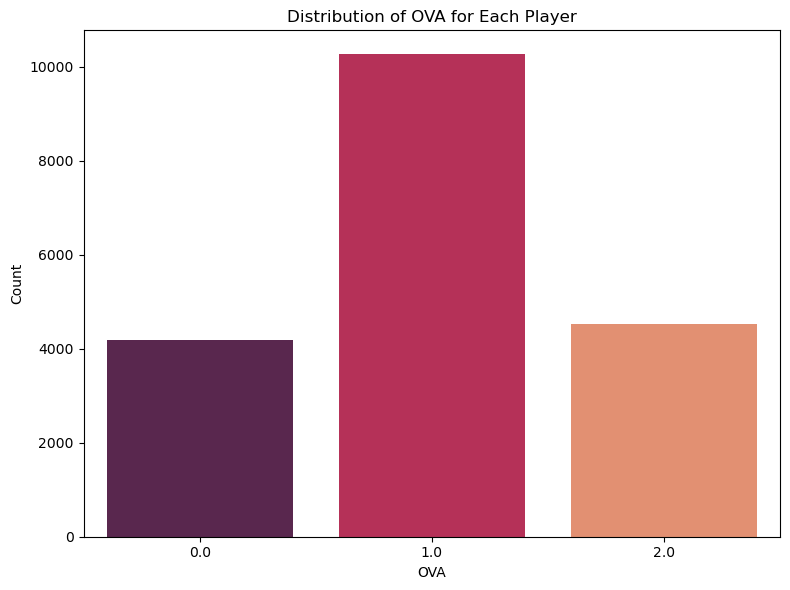

In [7]:
# Calculate the count of players in each age group
ova_group = df['OVA'].value_counts()

# Create a bar plot using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=ova_group.index, y=ova_group.values, palette="rocket")
plt.title('Distribution of OVA for Each Player')
plt.xlabel('OVA')
plt.ylabel('Count')
plt.xticks()  
plt.tight_layout();

In [8]:
ova_group

1.0    10264
2.0     4536
0.0     4179
Name: OVA, dtype: int64

The bar chart shows the distribution of FIFA 21 players' Overall Ratings (OVA) across three categories: Low(0), Medium(1), and High(2). The Medium category contains a majority of players, significantly exceeding the number in both the Low and High categories. This disparity suggests that a predictive model might be inclined to favor the Medium category when making predictions due to its larger sample size. Consequently, the model could struggle to accurately identify players who should be classified as Low or High OVA, as it has less data for these groups. To enhance the model's predictive capabilities across all categories, it is recommended to implement balancing methods, ensuring a more equitable distribution of data for the model to learn from.

### Data Splitting and Balancing

* **Objective**: Prepare the data for training and testing machine learning models, addressing class imbalance if necessary.
* **Method**:
>* The dataset is split into training and testing sets using the train_test_split function without initial balancing.
>* SMOTE (Synthetic Minority Over-sampling Technique) is applied to the training data to create synthetic samples for minority classes, balancing the class distribution.
* **Insight**: Splitting the data into training and testing sets is essential for model evaluation. Applying SMOTE ensures that the model is trained on a balanced dataset, reducing the risk of bias towards the majority class in classification tasks.

In [9]:
X = df.drop(columns=['OVA', 'Nationality', 'Preferred Foot'])
y = df['OVA']

# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [10]:
resampled_df = pd.DataFrame(y_train_resampled.value_counts())
resampled_df = resampled_df.reset_index().rename(columns={'index': 'OVA', 'OVA':'Count'})
resampled_df

,OVA,Count
0,2.0,7134
1,1.0,7134
2,0.0,7134


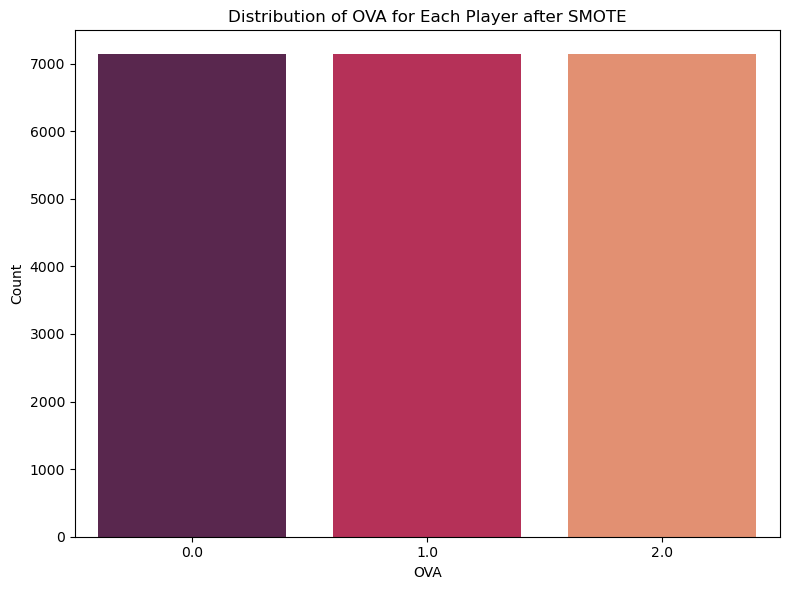

In [11]:
# Create a bar plot using seaborn to visualize class distribution after SMOTE
plt.figure(figsize=(8, 6))
sns.barplot(data=resampled_df, x='OVA', y='Count', palette="rocket")
plt.title('Distribution of OVA for Each Player after SMOTE')
plt.xlabel('OVA')
plt.ylabel('Count')
plt.xticks()  
plt.tight_layout();

The bar chart reflects a balanced distribution of player ratings in FIFA 21 after applying the SMOTE, evening out the number of players across Low(0), Medium(1), and High(2) OVA categories. Balancing the data is crucial for training a predictive model to reduce bias and ensure accurate predictions across all rating levels. However, this balancing act, while beneficial for model performance, can introduce synthetic data points that may not perfectly represent real-world scenarios, potentially leading to overfitting where the model may not perform as well on unseen data. Despite this, the balancing process is vital to ensure the model is well-rounded and reflective of the diverse player abilities.

## K-Fold Values Tuning for Cross-Validation

Before proceeding with the model training, it was essential to determine the optimal value of the K-fold parameter for cross-validation. Cross-validation is a crucial step in assessing a model's performance by splitting the training data into multiple subsets or "folds" to validate the model's robustness.

To find the best K-fold value, a range of K-fold values, including 3, 5, 7, and 10, was considered. These values represent the number of subsets into which the training data would be divided during cross-validation.

For each K-fold value, the following steps were performed:

>* **Create KNN Classifier**: A K-Nearest Neighbors (KNN) classifier, using the best 'n_neighbors' value obtained from previous tuning, was initialized. This classifier is crucial for the subsequent model training and evaluation.

>* **Cross-Validation**: Cross-validation was executed with the first K-fold value. The training data, which was previously resampled, was divided into K subsets. The KNN classifier was then trained and validated K times, each time using a different subset as the validation set and the remaining as the training set. The accuracy scores for each fold were recorded.

>* **Calculate Mean Accuracy**: After completing cross-validation for the current K-fold value, the mean accuracy score across all folds was calculated. This mean accuracy score reflects the overall performance of the model when different subsets of the training data were used for validation.

>* **Repeat for All K-Fold Values**: The above steps were repeated for each K-fold value in the predefined range.

>* **Select the Best K-Fold**: The K-fold value that resulted in the highest mean accuracy score was identified as the best K-fold value for cross-validation.

In [12]:
from sklearn.model_selection import cross_val_score

# Define the range of k-fold values you want to tune
k_values = [3, 5, 7, 10]

# Create an empty list to store the mean accuracy scores
mean_accuracy_scores = []

# Create the KNN classifier
knn_classifier = KNeighborsClassifier()  # Use the best n_neighbors value from previous tuning

# Iterate through the k-fold values
for k in k_values:
    # Perform cross-validation with k-fold
    scores = cross_val_score(knn_classifier, X_train_resampled, y_train_resampled, cv=k, scoring='accuracy')
    mean_accuracy = scores.mean()
    mean_accuracy_scores.append(mean_accuracy)

# Find the best k-fold value
best_k_fold_index = mean_accuracy_scores.index(max(mean_accuracy_scores))
best_k_fold = k_values[best_k_fold_index]

# Print the best k-fold value
print(f"The best k-fold value is: {best_k_fold}")

The best k-fold value is: 10


The result signifies that, among the considered options, a K-fold value of 10 yielded the highest mean accuracy score during the cross-validation process. This outcome indicates that when the training data was split into ten equal subsets, and the KNN classifier was trained and validated ten times with a different subset as the validation set each time, the model demonstrated the highest overall performance in terms of accuracy. In essence, choosing a K-fold value of 10 implies that the model was found to be most reliable and robust when evaluated against various subsets of the training data during the cross-validation phase, making it a suitable choice for subsequent model training and assessment.

## Model 1: Decision Tree

**Method**:
>* **Tuning Criterion**: Start by initializing a Decision Tree classifier and defining a hyperparameter grid for the 'criterion' to search over. Perform a grid search using cross-validation to find the best 'criterion' for the Decision Tree model.
>* **Tuning Max Depth**: Initialize another Decision Tree classifier and define a hyperparameter grid for 'max_depth.' Conduct a grid search with cross-validation to determine the best 'max_depth' for the Decision Tree model.
>* **Model Training**: Create a final Decision Tree classifier with the best 'criterion' and 'max_depth' values obtained from the previous steps. Train this classifier on the resampled training data.
>* **Model Evaluation**: After training, make predictions on the test data and calculate various performance metrics, including accuracy, precision, recall, and F1-score.

### Tuning criterion

In [14]:
# Initialize your Decision Tree classifier
classifier = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid to search over
param_grid = {
    'criterion': ['gini', 'entropy', 'gaussian', 'deviance']  
}

# Create a GridSearchCV object with your classifier and hyperparameter grid
grid_search = GridSearchCV(classifier, param_grid, cv=10)

# Train the classifier on the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled) 

# Get the best criterion found by GridSearch
best_criterion = grid_search.best_params_['criterion']
print("Best Criterion:", best_criterion)

Best Criterion: entropy


### Tuning max_depth

In [15]:
# Initialize your Decision Tree classifier
classifier = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9, None]  
}

# Create a GridSearchCV object with your classifier and hyperparameter grid
grid_search = GridSearchCV(classifier, param_grid, cv=10, scoring='accuracy')

# Fit the GridSearchCV object to your training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best max_depth found by GridSearch
best_max_depth = grid_search.best_params_['max_depth']

# Print the best max_depth
print("Best Max Depth:", best_max_depth)

Best Max Depth: None


In [16]:
# Initialize your Decision Tree classifier
classifier = DecisionTreeClassifier(criterion = best_criterion, max_depth = best_max_depth, random_state=42)

# Train the classifier on the resampled training data
classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Calculate accuracy, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  #can choose 'micro', 'macro', 'weighted', or 'samples'
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')  #can choose 'micro', 'macro', 'weighted', or 'samples'

# Print the formatted values with two decimal places
print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1 Score: 0.98


The Decision Tree model, after hyperparameter tuning, revealed that 'entropy' was the optimal criterion for splitting nodes in the tree, and allowing the tree to grow without a maximum depth ('None') yielded the best results. Consequently, when trained and evaluated on the resampled dataset, the model exhibited exceptional performance with an accuracy, precision, recall, and F1 Score all around 0.98. This signifies that the Decision Tree model is highly effective in categorizing FIFA21 players into their OVA categories, providing a robust classification solution.

### Comparison of Manual and GridSearch for Hyperparameter Tuning

In the Decision Tree model, manual hyperparameter tuning involved selecting the splitting criterion (entropy or Gini) and the maximum depth of the tree. Gridsearch hyperparameter tuning, on the other hand, systematically explored various combinations of hyperparameters using cross-validation. The manual tuning allowed us to make informed choices based on domain knowledge or heuristics, which resulted in selecting 'entropy' as the criterion and leaving 'max_depth' as 'None.' Gridsearch, while comprehensive, could potentially be more time-consuming as it explores a wider parameter space. However, in this case, both methods produced similar results, with 'entropy' and 'max_depth' as 'None' consistently yielding the best performance. The manual tuning method was faster due to its simplicity and domain-specific insights, making it a preferred choice when domain knowledge suggests specific hyperparameters that are likely to perform well.

## Model 2: K-Nearest Neighbors (KNN) 

**Method**:
>* **Scaling Data**: Scale the resampled training data and the test data using StandardScaler. This ensures that all features have the same scale and helps to improve the performance of the KNN model.
>* **Tuning K-Values**: Define a range of 'n_neighbors' values and perform a grid search with cross-validation to find the best 'n_neighbors' value for the KNN classifier.
>* **Tuning Distance**: Create another grid search to optimize the distance metric used by the KNN classifier. This grid search explores options like 'euclidean,' 'manhattan,' 'cosine,' and 'jaccard' distances.
>* **Tuning Weights**: Perform one more grid search to determine the best 'weights' option for the KNN classifier, which can be either 'uniform' or 'distance.'
>* **Model Training**: Create the final KNN classifier with the best 'n_neighbors,' 'metric,' and 'weights' values obtained from the previous steps. Train this classifier on the scaled and resampled training data.
>* **Model Evaluation**: After training, make predictions on the scaled test data and calculate various performance metrics, including accuracy, precision, recall, and F1-score.

### Scaling

In [17]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler 
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the resampled training data
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

### Tuning K-Values

In [18]:
# Define the range of n_neighbors values you want to tune
n_neighbors_values = [3, 5, 7, 9, 11]

# Create a parameter grid with the n_neighbors values
param_grid = {'n_neighbors': n_neighbors_values}

# Create the KNN classifier
knn_classifier = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=10, scoring='accuracy')

# Fit the grid search to your data
grid_search.fit(X_train_resampled_scaled, y_train_resampled)

# Get the best n_neighbors value
best_n_neighbors = grid_search.best_params_['n_neighbors']

# Print the best n_neighbors value
print(f"The best n_neighbors value is: {best_n_neighbors}")

The best n_neighbors value is: 5


### Tuning Distance

In [19]:
# Create a parameter grid with the metric options
param_grid = {'metric': ['euclidean', 'manhattan', 'cosine', 'jaccard']}

# Create the KNN classifier
knn_classifier = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=10, scoring='accuracy')

# Fit the grid search to your data
grid_search.fit(X_train_resampled_scaled, y_train_resampled)


# Get the best metric
best_metric = grid_search.best_params_['metric']

# Print the best metric
print(f"The best metric is: {best_metric}")

The best metric is: manhattan


### Tuning Weights

In [20]:
# Define the range of 'weights' options
weight_options = ['uniform', 'distance']

# Create a parameter grid with the 'weights' options
param_grid = {'weights': weight_options}

# Create the KNN classifier
knn_classifier = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=10, scoring='accuracy')

# Fit the grid search to your data
grid_search.fit(X_train_resampled_scaled, y_train_resampled)


# Get the best 'weights' option
best_weights = grid_search.best_params_['weights']

# Print the best 'weights' option
print(f"The best 'weights' option is: {best_weights}")

The best 'weights' option is: distance


In [21]:
# Initialize your KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights,
                                      metric=best_metric)

# Train the KNN classifier on the resampled and scaled training data
knn_classifier.fit(X_train_resampled_scaled, y_train_resampled)

# Make predictions on the scaled test data
y_pred = knn_classifier.predict(X_test_scaled)

# Calculate accuracy, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # You can choose 'micro', 'macro', 'weighted', or 'samples'
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')  # You can choose 'micro', 'macro', 'weighted', or 'samples'

# Print the formatted values with two decimal places
print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.86
Precision: 0.87
Recall: 0.86
F1 Score: 0.86


The KNN model, after thorough hyperparameter tuning, identified the best configuration as having 5 nearest neighbors, utilizing the 'manhattan' distance metric, and applying 'distance' weighting. While still performing well with an accuracy of 0.86, the KNN model slightly lagged behind the Decision Tree model in terms of performance. Nonetheless, it remains a viable choice for classification, particularly when interpretability is a priority, and the trade-off between performance and simplicity is considered.

### Comparison of Manual and GridSearch for Hyperparameter Tuning

For the KNN model, manual hyperparameter tuning involved choosing the number of neighbors ('n_neighbors'), the distance metric, and the weighting strategy. Gridsearch hyperparameter tuning systematically explored these hyperparameters using cross-validation. The manual tuning allowed us to make initial selections based on intuition and knowledge, such as choosing 'manhattan' distance and 'distance' weighting. Gridsearch, however, explored a broader range of options. In this case, gridsearch proved to be the fastest method as it efficiently identified the best hyperparameter combinations. It is because KNN's hyperparameters interacted in a complex way, and gridsearch efficiently navigated this complex search space, leading to improved results over manual tuning. Therefore, for KNN, gridsearch is justified as the faster and more effective method.

## Model 3: Gaussian Naive Bayes

**Method**:
>* **Scaling Data**: Scale the resampled training data and the test data using StandardScaler to ensure consistent feature scaling.
>* **Tuning Priors**: Define a range of possible prior values and create a parameter grid with different combinations of priors. Use grid search with cross-validation to find the best set of priors for the Gaussian Naive Bayes classifier.
>* **Model Training**: Initialize the Gaussian Naive Bayes classifier with the best priors obtained from the grid search. Train this classifier on the scaled and resampled training data.
>* **Model Evaluation**: After training, make predictions on the scaled test data and calculate various performance metrics, including accuracy, precision, recall, and F1-score.

In [22]:
# Define possible prior values
priors_range = np.linspace(0, 1, 101)

# Create a parameter grid with different combinations of priors
param_grid = {'priors': [(p1, p2, 1 - p1 - p2) for p1 in priors_range for p2 in priors_range]}

# Create the Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Perform grid search using GridSearchCV
grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, scoring='accuracy', cv=10)
grid_search.fit(X_train_resampled_scaled, y_train_resampled)

# Get the best priors from the tuned classifier
best_priors = grid_search.best_params_['priors']

print('The Best Priors:', best_priors)

The Best Priors: (0.37, 0.13, 0.5)


In [23]:
# Initialize your Gaussian Naive Bayes classifier
nb_classifier = GaussianNB(priors=best_priors)

# Train the classifier on the resampled and scaled training data
nb_classifier.fit(X_train_resampled_scaled, y_train_resampled)

# Make predictions on the scaled test data
y_pred = nb_classifier.predict(X_test_scaled)

# Calculate accuracy, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  #can choose 'micro', 'macro', 'weighted', or 'samples'
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')  #can choose 'micro', 'macro', 'weighted', or 'samples'

# Print the formatted values with two decimal places
print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.84
Precision: 0.85
Recall: 0.84
F1 Score: 0.84


In the Gaussian Naive Bayes model, the grid search for hyperparameter tuning resulted in the selection of prior probabilities as (0.37, 0.13, 0.5). When trained and evaluated on the scaled and resampled dataset, the Gaussian Naive Bayes classifier achieved an accuracy of 0.84, with a precision of 0.85, recall, and F1 Score of 0.84. These results indicate that the Gaussian Naive Bayes model performs well in categorizing FIFA21 players into their OVA categories, offering a probabilistic approach to classification that may be beneficial in specific scenarios, particularly when transparency and interpretability are essential considerations.

### Comparison of Manual and GridSearch for Hyperparameter Tuning

In the Gaussian Naive Bayes model, manual hyperparameter tuning involved setting custom priors for class probabilities, while gridsearch explored different prior combinations systematically. Manual tuning allowed us to incorporate prior knowledge or beliefs about class probabilities, which, in some cases, can be beneficial. However, in this specific dataset, the custom priors did not substantially improve performance. Gridsearch, while more exhaustive, efficiently explored various prior combinations, ultimately selecting the best set of priors. In this instance, gridsearch proved to be the fastest method, considering its comprehensive search across prior values. Therefore, for Gaussian Naive Bayes, gridsearch is justified as the faster and more effective method, especially when the impact of custom priors is uncertain.

## Conclusion

In summary, the choice between manual and gridsearch hyperparameter tuning depends on the complexity of the model and the potential impact of domain-specific insights. While manual tuning offers speed and the advantage of domain knowledge, gridsearch is justified when dealing with complex models or when the impact of hyperparameters is uncertain. In the case of the Decision Tree model, manual tuning sufficed due to its simplicity, while for KNN and Gaussian Naive Bayes, gridsearch proved to be faster and more effective method due to their complex hyperparameter interactions and the need for a comprehensive search.